# slope variance
What section of slope fitting would provide the greatest amount of variance? This might be the best way to find significant differences between subjects.

In [1]:
%matplotlib inline
import os
import glob
import seaborn
import numpy as np
import scipy as sp
import pandas as pd
import scipy.io
import scipy.signal
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import linregress

mpl.rcParams['figure.figsize'] = (16, 10)
srate = 512

In [2]:
def import_subjects(import_path):
    subj = {}
    matfiles = []
    for root, dirs, files in os.walk(import_path):
        matfiles += glob.glob(os.path.join(root, '*.mat'))
    for i in range(len(matfiles)):
        datafile = sp.io.loadmat(matfiles[i])
        subj[i] = {}
        subj[i]['name'] = str(np.squeeze(datafile['name']))
        subj[i]['data'] = np.squeeze(datafile['data'])
    return subj

In [3]:
subj = import_subjects('../data/examine-slope-fit/150hz-filt/')

In [4]:
def ransac_slope(f, psd, lofreq, hifreq):
    """
    Robustly fits line to the PSD, using the RANSAC algorithm. 
    Returns slope and fit line.
    """
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(f[lofreq*2:hifreq*2], np.log10(psd[lofreq*2:hifreq*2]))
    fit_line = model_ransac.predict(f)
    return model_ransac.estimator_.coef_[0][0] * (10**2), fit_line

def linreg_slope(f, psd, lofreq, hifreq):
    """
    Fits line to the PSD, using regular linear regression.
    Returns slope and fit line.
    """
    model = linear_model.LinearRegression()
    model.fit(f[2*2:24*2], np.log10(psd[2*2:24*2]))
    fit_line = model.predict(f)
    return model.coef_[0][0] * (10**2), fit_line

def process_subjects_ransac(subj):
    """
    Does the things.
    """
    for i in subj:
        for ch in range(len(subj[i]['data'])):
            subj[i][ch] = {}

            f, psd = sp.signal.welch(subj[i]['data'][ch], srate, nperseg=srate*2, noverlap=srate, window='hamming')
            f   = f.reshape((len(f), 1))
            psd = psd.reshape((len(psd), 1))
            
            subj[i][ch]['f'] = f
            subj[i][ch]['psd'] = psd
            
            # Remove alpha peak from the power spectrum:        
            subj[i][ch]['psd_rm_alpha'] = np.delete(psd, range(7*2, 14*2))
            subj[i][ch]['f_rm_alpha']   = np.delete(f, range(7*2, 14*2))
            subj[i][ch]['psd_rm_alpha'] = subj[i][ch]['psd_rm_alpha'].reshape((len(subj[i][ch]['psd_rm_alpha']), 1))
            subj[i][ch]['f_rm_alpha']   = subj[i][ch]['f_rm_alpha'].reshape((len(subj[i][ch]['f_rm_alpha']), 1))
            
            # Compute slope of this channel, and store fit line
            subj[i][ch]['ransac_2-24'], subj[i][ch]['lransac_2-24'] = ransac_slope(subj[i][ch]['f_rm_alpha'], subj[i][ch]['psd_rm_alpha'], 2, 24)
            subj[i][ch]['ransac_20-40'], subj[i][ch]['lransac_20-40'] = ransac_slope(subj[i][ch]['f_rm_alpha'], subj[i][ch]['psd_rm_alpha'], 20, 40)
            subj[i][ch]['ransac_40-80'], subj[i][ch]['lransac_40-80'] = ransac_slope(subj[i][ch]['f_rm_alpha'], subj[i][ch]['psd_rm_alpha'], 40, 80)
            subj[i][ch]['ransac_20-30'], subj[i][ch]['lransac_20-30'] = ransac_slope(subj[i][ch]['f_rm_alpha'], subj[i][ch]['psd_rm_alpha'], 20, 30)
            subj[i][ch]['ransac_50-150'], subj[i][ch]['lransac_50-150'] = ransac_slope(subj[i][ch]['f_rm_alpha'], subj[i][ch]['psd_rm_alpha'], 50, 150)
            
        # Compute average slope for this subject
        subj[i]['avg_ransac_2-24'] = np.mean([subj[i][ch]['ransac_2-24'] for ch in range(len(subj[i]['data']))])
        subj[i]['avg_ransac_20-30'] = np.mean([subj[i][ch]['ransac_20-30'] for ch in range(len(subj[i]['data']))])
        subj[i]['avg_ransac_20-40'] = np.mean([subj[i][ch]['ransac_20-40'] for ch in range(len(subj[i]['data']))])
        subj[i]['avg_ransac_40-80'] = np.mean([subj[i][ch]['ransac_40-80'] for ch in range(len(subj[i]['data']))])
        subj[i]['avg_ransca_50-150'] = np.mean([subj[i][ch]['ransac_50-150'] for ch in range(len(subj[i]['data']))])
    return subj

def process_subjects_linreg(subj):
    """
    Does the things.
    """
    for i in subj:
        for ch in range(len(subj[i]['data'])):
            subj[i][ch] = {}

            f, psd = sp.signal.welch(subj[i]['data'][ch], srate, nperseg=srate*2, noverlap=srate, window='hamming')
            f   = f.reshape((len(f), 1))
            psd = psd.reshape((len(psd), 1))
            
            subj[i][ch]['f'] = f
            subj[i][ch]['psd'] = psd
            
            # Remove alpha peak from the power spectrum:        
            subj[i][ch]['psd_rm_alpha'] = np.delete(psd, range(7*2, 14*2))
            subj[i][ch]['f_rm_alpha']   = np.delete(f, range(7*2, 14*2))
            subj[i][ch]['psd_rm_alpha'] = subj[i][ch]['psd_rm_alpha'].reshape((len(subj[i][ch]['psd_rm_alpha']), 1))
            subj[i][ch]['f_rm_alpha']   = subj[i][ch]['f_rm_alpha'].reshape((len(subj[i][ch]['f_rm_alpha']), 1))
            
            # Compute slope of this channel, and store fit line
            subj[i][ch]['linreg_2-24'], subj[i][ch]['llinreg_2-24'] = linreg_slope(subj[i][ch]['f_rm_alpha'], subj[i][ch]['psd_rm_alpha'], 2, 24)
            subj[i][ch]['linreg_20-40'], subj[i][ch]['llinreg_20-40'] = linreg_slope(subj[i][ch]['f_rm_alpha'], subj[i][ch]['psd_rm_alpha'], 20, 40)
            subj[i][ch]['linreg_40-80'], subj[i][ch]['llinreg_40-80'] = linreg_slope(subj[i][ch]['f_rm_alpha'], subj[i][ch]['psd_rm_alpha'], 40, 80)
            subj[i][ch]['linreg_20-30'], subj[i][ch]['llinreg_20-30'] = linreg_slope(subj[i][ch]['f_rm_alpha'], subj[i][ch]['psd_rm_alpha'], 20, 30)
            subj[i][ch]['linreg_50-150'], subj[i][ch]['llinreg_50-150'] = linreg_slope(subj[i][ch]['f_rm_alpha'], subj[i][ch]['psd_rm_alpha'], 50, 150)
            
        # Compute average slope for this subject
        subj[i]['avg_linreg_2-24'] = np.mean([subj[i][ch]['linreg_2-24'] for ch in range(len(subj[i]['data']))])
        subj[i]['avg_linreg_20-30'] = np.mean([subj[i][ch]['linreg_20-30'] for ch in range(len(subj[i]['data']))])
        subj[i]['avg_linreg_20-40'] = np.mean([subj[i][ch]['linreg_20-40'] for ch in range(len(subj[i]['data']))])
        subj[i]['avg_linreg_40-80'] = np.mean([subj[i][ch]['linreg_40-80'] for ch in range(len(subj[i]['data']))])
        subj[i]['avg_ransca_50-150'] = np.mean([subj[i][ch]['linreg_50-150'] for ch in range(len(subj[i]['data']))])
    return subj

In [5]:
subjr = process_subjects_ransac(subj)

In [6]:
subjl = process_subjects_linreg(subj)

In [6]:
np.save('../data/subj150-diff-fits.npy', subj)

In [8]:
print('2-24:   ', np.var([subj[i]['avg_ransac_2-24'] for i in subj]))
print('20-30:  ', np.var([subj[i]['avg_ransac_20-30'] for i in subj]))
print('20-40:  ', np.var([subj[i]['avg_ransac_20-40'] for i in subj]))
print('40-80:  ', np.var([subj[i]['avg_ransac_40-80'] for i in subj]))
print('50-150: ', np.var([subj[i]['avg_ransca_50-150'] for i in subj]))

2-24:    2.07884579093
20-30:   4.47444552188
20-40:   1.95292060233
40-80:   0.0977445550114
50-150:  0.0168687787253


In [11]:
print('2-24:   ', np.var([subjl[i]['avg_linreg_2-24'] for i in subjl]))
print('20-30:  ', np.var([subjl[i]['avg_linreg_20-30'] for i in subjl]))
print('20-40:  ', np.var([subjl[i]['avg_linreg_20-40'] for i in subjl]))
print('40-80:  ', np.var([subjl[i]['avg_linreg_40-80'] for i in subjl]))
print('50-150: ', np.var([subjl[i]['avg_ransca_50-150'] for i in subjl]))

2-24:    1.55509882932
20-30:   1.55509882932
20-40:   1.55509882932
40-80:   1.55509882932
50-150:  1.55509882932


So it looks like fitting to the 20-30 range provides the greatest amount of variance. However this might just be due to the fact that fitting to a smaller range (in this case to a 10 Hz range) is likely to produce higher variance.

(0, 100)

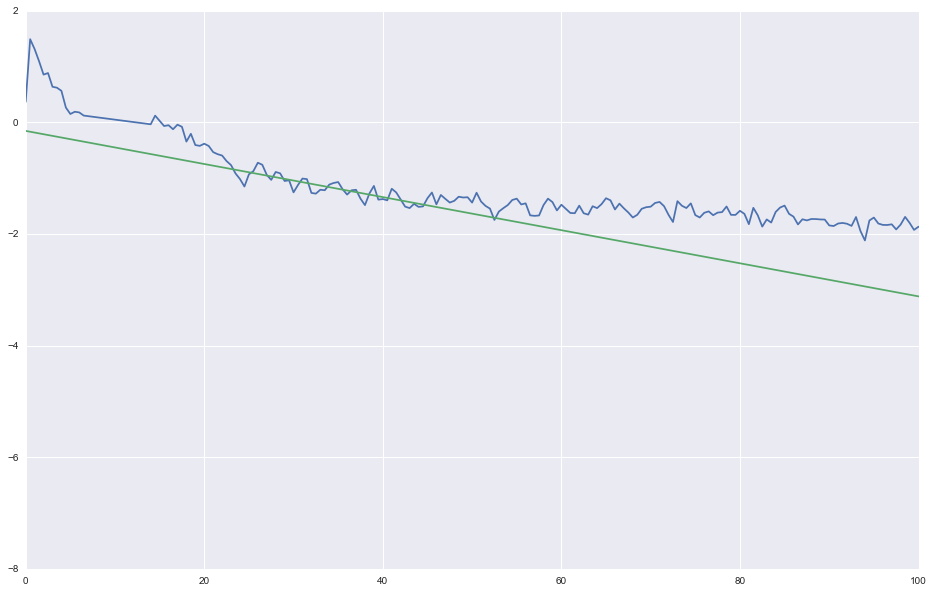

In [9]:
i = 0
plt.plot(subj[i][0]['f_rm_alpha'], np.log10(subj[i][0]['psd_rm_alpha']))
plt.plot(subj[i][0]['f_rm_alpha'], subj[i][0]['lransac_20-30'])
plt.xlim([0, 100])

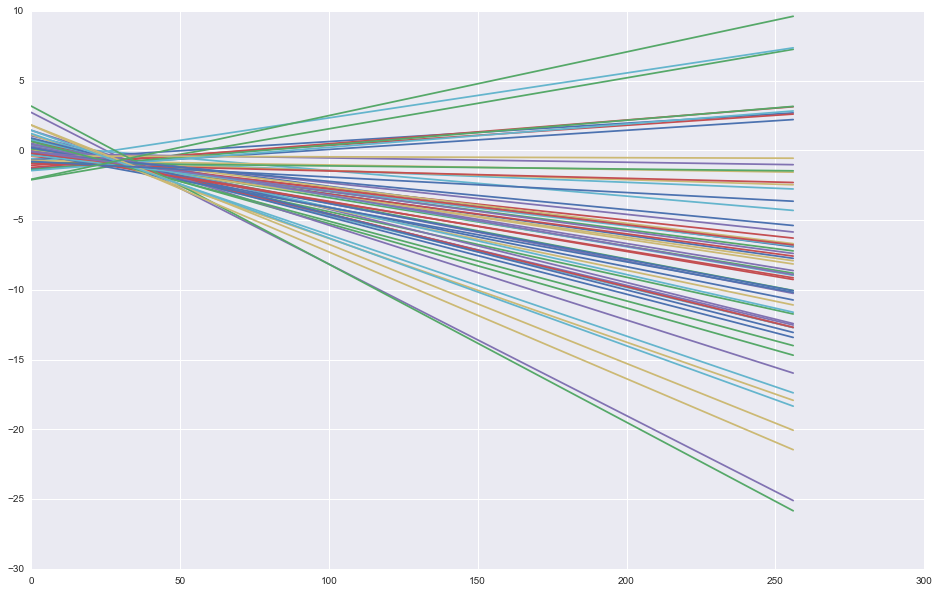

In [10]:
for i in range(len(subj)):
    plt.plot(subj[i][0]['f_rm_alpha'], subj[i][0]['lransac_20-30'])

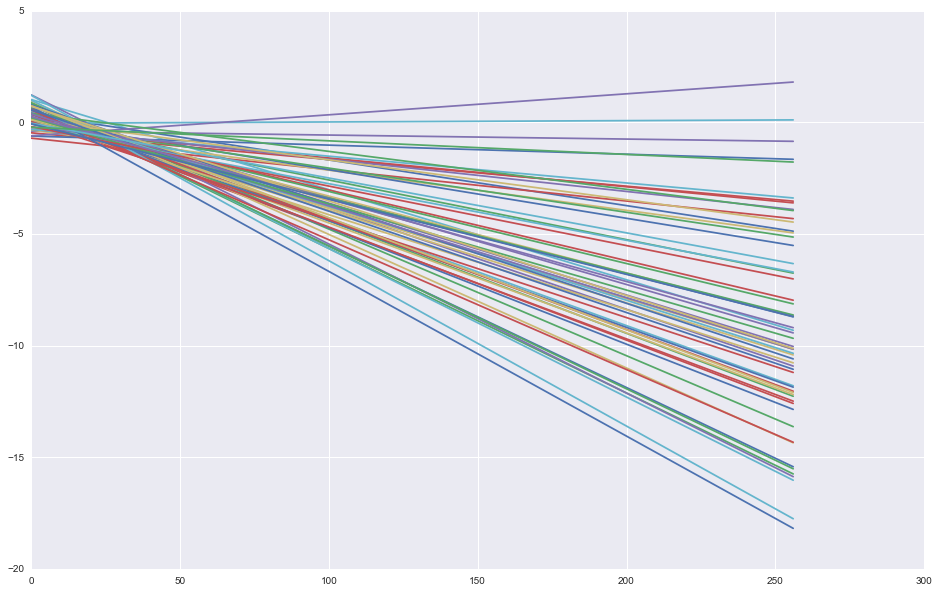

In [11]:
for i in range(len(subj)):
    plt.plot(subj[i][0]['f_rm_alpha'], subj[i][0]['lransac_2-24'])

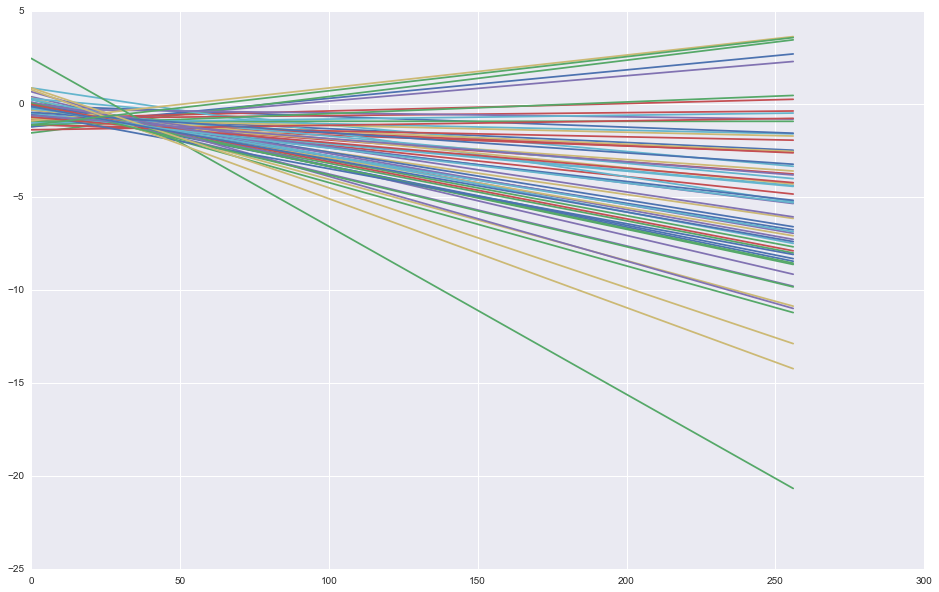

In [12]:
for i in range(len(subj)):
    plt.plot(subj[i][0]['f_rm_alpha'], subj[i][0]['lransac_20-40'])

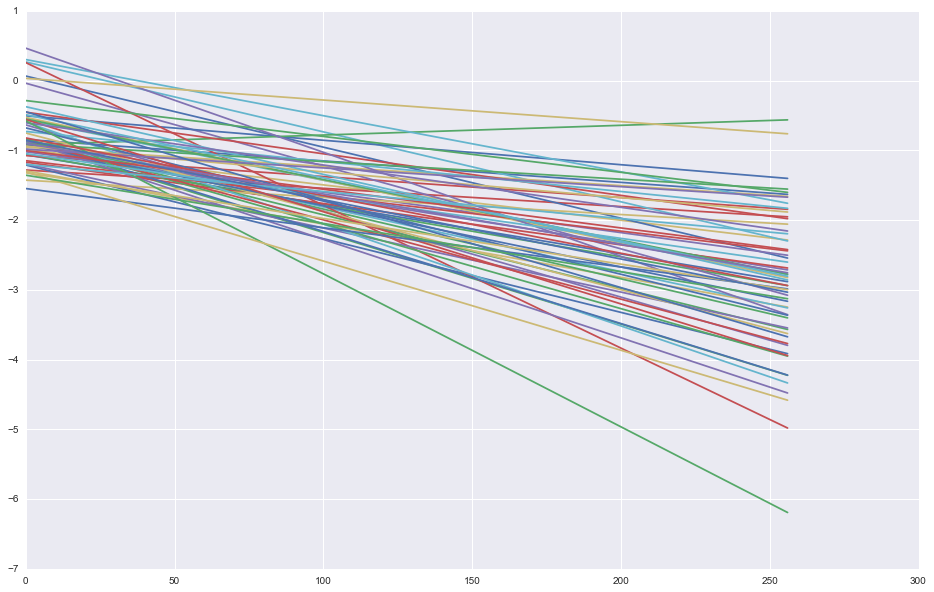

In [13]:
for i in range(len(subj)):
    plt.plot(subj[i][0]['f_rm_alpha'], subj[i][0]['lransac_40-80'])

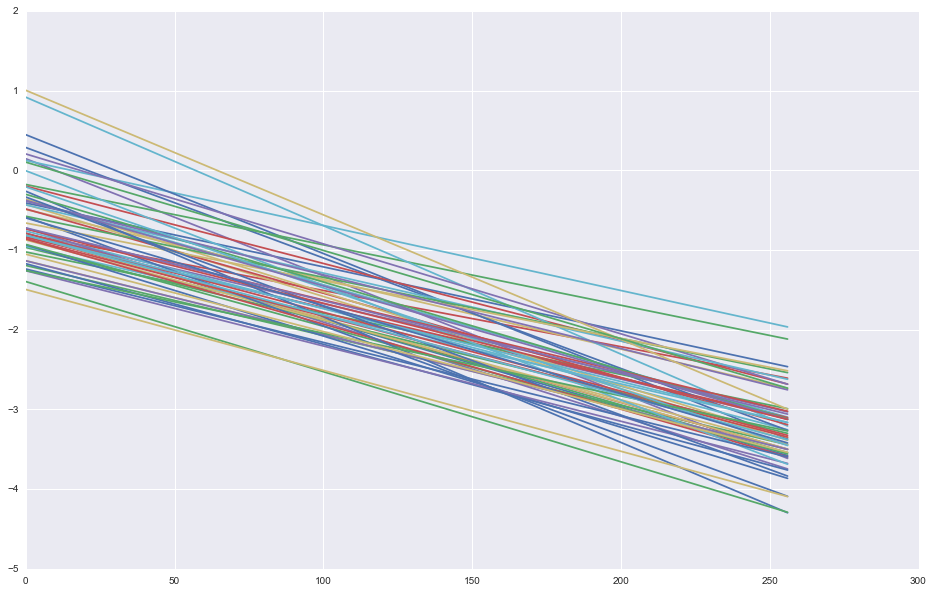

In [14]:
for i in range(len(subj)):
    plt.plot(subj[i][0]['f_rm_alpha'], subj[i][0]['lransac_50-150'])

# linear regression

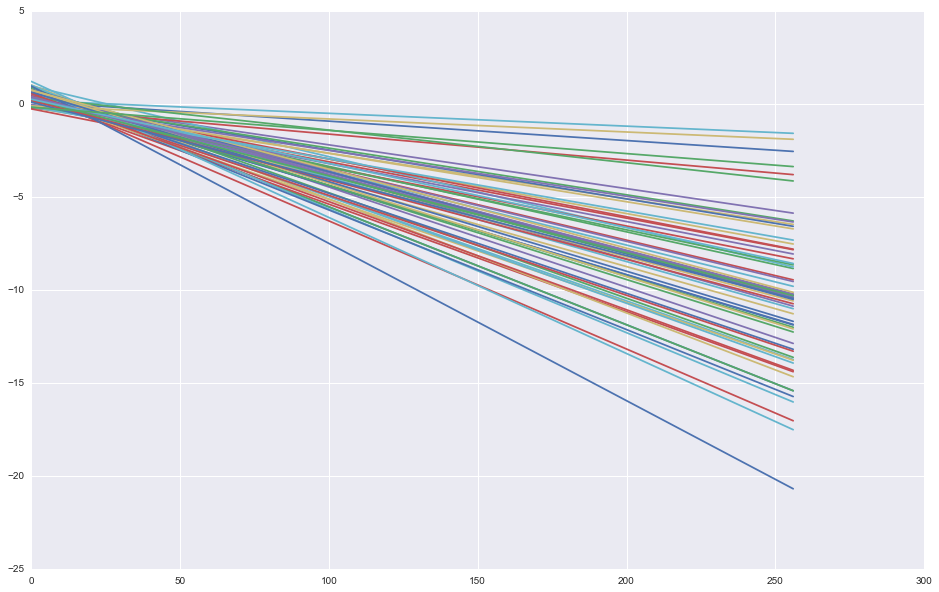

In [15]:
for i in range(len(subjl)):
    plt.plot(subjl[i][0]['f_rm_alpha'], subjl[i][0]['llinreg_2-24'])

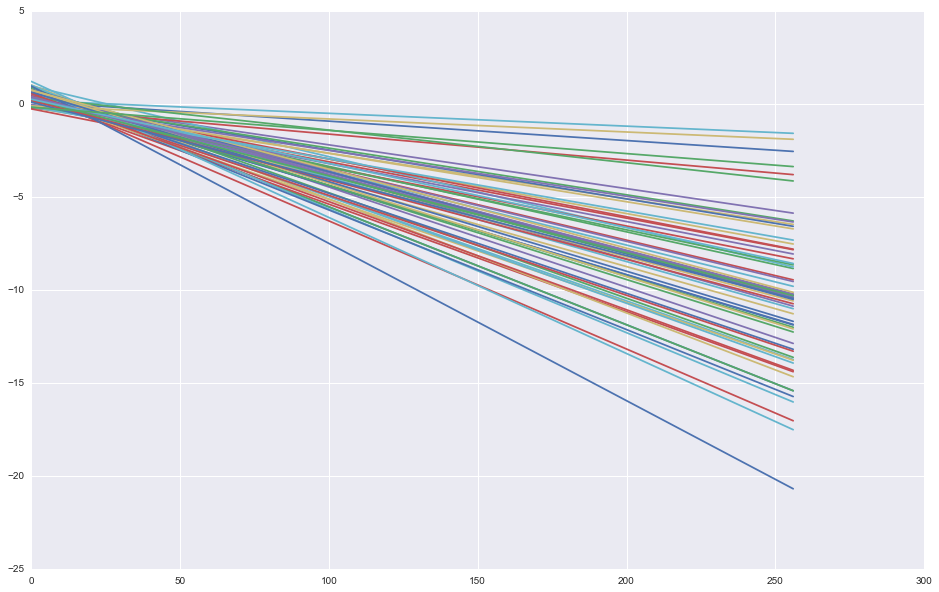

In [16]:
for i in range(len(subjl)):
    plt.plot(subjl[i][0]['f_rm_alpha'], subjl[i][0]['llinreg_20-30'])

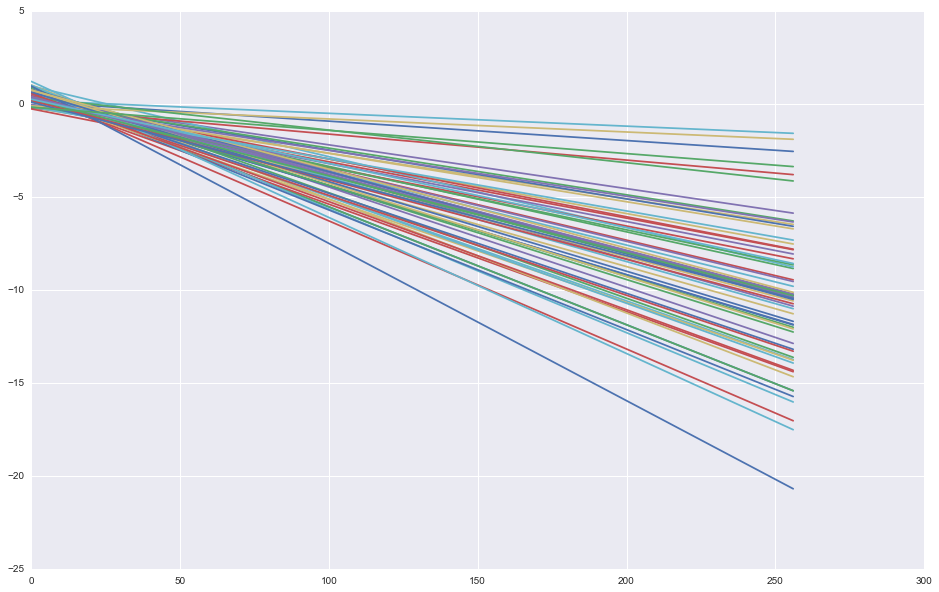

In [17]:
for i in range(len(subjl)):
    plt.plot(subjl[i][0]['f_rm_alpha'], subjl[i][0]['llinreg_20-40'])